Title:  CODTECH Task 3: Neural Style Transfer

Introduction: Explain what Neural Style Transfer is.

Setup:Google Colab (with GPU).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
# from google.colab import drive # if using Colab and need to mount drive

In [2]:
def vgg_layers(layer_names):
    """Creates a vgg model that returns a list of intermediate output values."""
    # Load our pretrained VGG19 model without the top (classification) layer
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False # Freeze the VGG layers

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [3]:
content_layers = ['block5_conv2'] # Usually a deeper layer for content
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
] # Multiple shallower layers for style

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [4]:
def load_img(path_to_img):
    max_dim = 512 # Resize images to a manageable size
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.LANCZOS)
    img = np.array(img)
    img = img.astype(np.float32)[np.newaxis, ...] / 255.0 # Normalize to [0, 1]
    return tf.convert_to_tensor(img)

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# VGG preprocessing (subtracting ImageNet means)
def vgg_preprocess(image):
    # Convert to BGR
    image = image * 255.0 # Scale back to [0, 255]
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [5]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

In [6]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0 # Scale to [0, 255]
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]

        content_features = [content_output
                            for content_output in content_outputs]

        return {'content': content_features, 'style': style_features}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_output - style_target)**2)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                             for content_output, content_target in zip(content_outputs, content_targets)])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Optional: Total variation loss
def total_variation_loss(image):
    x_deltas = tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :])
    y_deltas = tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])
    return tf.reduce_sum(x_deltas) + tf.reduce_sum(y_deltas)

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_output - style_target)**2)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                             for content_output, content_target in zip(content_outputs, content_targets)])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Optional: Total variation loss
def total_variation_loss(image):
    x_deltas = tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :])
    y_deltas = tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])
    return tf.reduce_sum(x_deltas) + tf.reduce_sum(y_deltas)

In [19]:
# Load your content and style images
content_path = 'your_content_image.jpg' # Replace with your image paths
style_path = 'your_style_image.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

# Calculate targets for content and style
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Initialize the generated image (e.g., as a copy of content image or random noise)
image = tf.Variable(content_image)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Weights for the loss components
style_weight = 1e-2 # Tune this!
content_weight = 1e4 # Tune this!
tv_weight = 30 # For total variation loss (optional)

@tf.function # Decorator to compile the function into a TensorFlow graph for speed
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)
        # Add total variation loss if you want
        # loss += tv_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)) # Keep pixel values in [0, 1]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 512, 341, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


In [20]:
content_image = load_img(content_path)
style_image = load_img(style_path)

In [21]:
image = tf.Variable(content_image)

....................................................................................................
Epoch 1 complete
....................................................................................................
Epoch 2 complete
....................................................................................................
Epoch 3 complete
....................................................................................................
Epoch 4 complete
....................................................................................................
Epoch 5 complete
....................................................................................................
Epoch 6 complete
....................................................................................................
Epoch 7 complete
....................................................................................................
Epoch 8 complete
........................................................

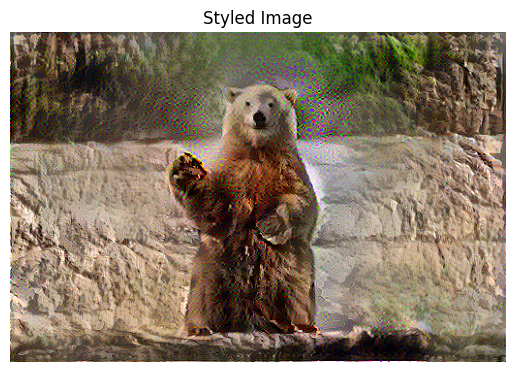

In [22]:
epochs = 10
steps_per_epoch = 100 # Or adjust based on how long you want it to run

start = time.time()

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image) # This calls the function you've shown in the screenshot
        print(".", end='', flush=True)
    # Optional: Clear output and display current image after each epoch
    # from IPython import display
    # display.clear_output(wait=True)
    # imshow(image.read_value(), 'Train step: {}'.format(n * steps_per_epoch + m))
    print("\nEpoch {} complete".format(n + 1)) # Added \n for cleaner output

end = time.time()
print("Total time: {:.1f}s".format(end-start))

# After the loop, display and save the final image
final_image = tf.squeeze(image.read_value(), axis=0)
plt.imshow(final_image)
plt.axis('off')
plt.title('Styled Image')
plt.savefig('styled_image.png', bbox_inches='tight', pad_inches=0)
plt.show()